In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import json
import re

# Text preprocessing modules
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string
import spacy

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

In [2]:
# View all columns
pd.set_option('display.max_columns', None)

# Reading Json Files

In [3]:
OUTBOUND_EMAIL = "Email - Outbound"
NOTE = "Note"

def select_text(comment, activity_type):
    """Exclude comments that are auto-generated"""
    
    if activity_type == OUTBOUND_EMAIL:
        # exclude auto-generated emails or zoom meetings
        if comment.startswith("THIS IS AN AUTO GENERATED EMAIL") or "inviting you to a scheduled Zoom meeting" in comment:
            comment = ""
    elif activity_type == NOTE:
        # exclude auto-generated notes
        if "Case file access password" in comment:
            comment = ""
    return comment 
            

In [4]:
def flatten(sr_dict):
    """Flatten json service request to top level dictionary, concatenate activities by their types"""
    
    out = {}
    try:
        # get all the fields in the details section
        out = sr_dict["details"]
        activities_dict = sr_dict["activities"]
        # loop through the activities and concatenate them by their types
        for activity in activities_dict:
            activity_type = activity["Type"]
            comment = select_text(activity["Comment"], activity_type)

            if comment:
                if activity_type in out:
                    out[activity_type].append(comment)

                else:
                    out[activity_type] = [comment]
    #except Exception as e:
        #print(e)
    finally:
        return out

In [5]:
def read_json_files_from_path(path):
    print("Reading from: " + path)
    #list of service request json files in the path 
    list_files = [sr for sr in os.listdir(path) if sr.startswith(("1-","C"))]

    #set up an empty list
    resultdict = []

    count = 0
    error = 0
    for f in list_files:
        with open(os.path.join(path, f), "r") as inputjson:
            count += 1
            service_request = json.load(inputjson)
            flat_sr = flatten(service_request)
            if not flat_sr:
                error += 1
            else:
                resultdict.append(flat_sr)
    print("Total file read: " + str(count))
    print("Total error file: " + str(error))
    return resultdict

In [6]:
path = "/data/nus/"
quarters = ["20q1","20q2","20q3","20q4", "21q1"]
combine = []

for quarter in quarters:
    combine.extend(read_json_files_from_path(path + quarter))
# normalize json into dataFrame
df = pd.DataFrame.from_dict(combine)
df.head(5)

Reading from: /data/nus/20q1
Total file read: 28768
Total error file: 98
Reading from: /data/nus/20q2
Total file read: 30508
Total error file: 81
Reading from: /data/nus/20q3
Total file read: 31087
Total error file: 126
Reading from: /data/nus/20q4
Total file read: 42008
Total error file: 99
Reading from: /data/nus/21q1
Total file read: 30650
Total error file: 114


,ROWID,SR_Number_Title,F5_SLM_Indicator,F5_Flash_Alert,SR_Number,SerialNumber,Abstract,F5_Base_Reg_Key,F5_Product_Description,F5_PS_Confirm_Flg,F5_Security_Flag,Status,Area,Sub_Status,F5_Product,F5_Platform,Sub_Area,Owner,F5_Product_Version,F5_Hotfix,Parent_SR_Number,Severity,Account,AccountLocation,Created,F5_Hot_Indicator,F5_Has_Service_Metric,F5_Last_Resolved_Date,ContactLastName,Contact_Email,F5_Time_Since_Last_Contact,F5_Ask_F5_ID,F5_Cloud_Platform,F5_Has_SKD_Session,ContactFirstName,ContactBusinessPhone,F5_Email_CC,F5_Duration,F5_Service_Level,F5_Contract_Number,F5_Has_Service_Orders,F5_Safety_Hazard,Source,F5_Entitlement_Account,F5_Supported_Programs,F5_CSP_Created_Date,F5_CSP_Last_Updated_Date,F5_Entitlement_Name,F5_Parent_Id,F5_Customer_Ticket_Number,F5_Entitlement_Type,F5_Time_To_SLA,F5_Last_Modified,F5_Entitlement_Status,F5_Free,F5_Has_Child,F5_Entitlement_Contract_Hours,F5_Special_Consideration,F5_Entitlement_Service_Level,F5_RMA_Type,F5_Resolution_Code,F5_Bugzilla_Ref_Num,F5_Warranty_Type,ClosedDate,F5_Hardware_Warranty,State,Country,F5_EUD_Result,F5_EUD_Summary,Created_By_Name,F5_Appliance_Engineering_Id,F5_SLM_Due_Date,Last_Updated_By_Login,Product_Part_Number,AspenNS_Name,AspenNS_Root,AspenNS_Closed,Parent_AspenNS_Name,Notes,Call - Outbound,Email - Outbound,Email - Inbound,Research,"Problem, Analysis, Resolution",Plan of Action,Call - Inbound,Manager Review,NS Shift Rpt - Monitor,NS Shift Rpt - Need New Owner,Mentor Review,QL Assignment,NS Shift Rpt - 24/7,QL Reassignment,To Do,SRT Mentor,RCA,ES Shift Rpt - Need New Owner,Wrong RMA Return,ES Shift Rpt - 24/7,Return to F5
0,1-2LG2L0T,C3134712,SLM Met,,C3134712,f5-teud-qsbg,7255 chassis has power but will not power back on,PHPAI-FDAPO-LBNOI-RJPTM-VLKUZFG,"EOS (19_10_01), BIG-IP 7055, WHITETHORNE 2U, A...",N,,Closed,Configuration,Closed,BIG-IP APM,"F5-BIG-LTM-7255V, D110",APM-AAA,ANAVARRO,13.1.1,,,2 - Site At Risk,Voya Financial,258777,11/8/2019 10:50:11 AM,,,11/8/2019 11:29:46 AM,CSP,networkers@list.voya.com,446 day 13 hr 49 min,,,Y,Voya Team,(904) 791-2601,,4 day 1 hr 43 min,1,AA409053,Y,,CSP,Westcon Group North America Inc,,11/8/2019 10:47:03 AM,11/11/2019 10:30:39 AM,Premium - Sun-Sat (24hrs/day),ZVLKUZFG,,Premium,0,11/28/2019 1:24:56 AM,Active - 12/28/2021,,N,Sun-Sat (24hrs/day),,Level 1-3,Advanced Exchange,Hardware Replacement,,,11/12/2019 12:34:05 PM,,MN,UNITED STATES,Could Not Run,The unit is not detecting power and does not g...,EAIUSER,D110,11/8/2019 11:47:03 AM,SADMIN,200-0394-01,pate,C3134712,True,None,"[New case, C3134712, Severity ""Site at Risk (S...","[Calling customer, In the phone call the custo...",[From: Aspensupport\nTo: networkers@list.voya....,"[From: Nick.Volonakis@voya.com\nTo: ""c.emailcl...",[You can follow the next article. Please let m...,[Problem Specification: 7255 chassis has power...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-2LTW2ZZ,C3142146,FR set after SLM Met,,C3142146,f5-lmty-tvyn,BIG-IP became Offline status after confg sync....,AVTSU-WHBVT-PYMXQ-VGEIS-FAGNCOW,"EOS (18_04_01), BIG-IP, 2000 AC PLATFORM, STRA...",N,,Closed,Software,Closed,BIG-IP ASM,"F5-BIG-ASM-2000S, C112",Defect,MINAMIDE,13.1.1,,,3 - Performance Degraded,Tokyo Electron Device Ltd.,1205,11/17/2019 6:38:15 PM,,,11/20/2019 6:54:21 PM,Niwano,niwano.m@teldevice.co.jp,416 day 1 hr 20 min,,,Y,Masahiro,+813-6866-7383,,54 day 6 hr 53 min,3,SA3000881,N,,CSP,Tokyo Electron Device Ltd,,11/17/2019 6:33:39 PM,11/18/2019 9:56:04 PM,Standard - Mon-Fri. (8AM to 6PM),ZFAGNCOW,TD13407,Standard,0,1/27/2020 1:17:07 AM,Active - 01/16/2023,,N,Mon-Fri. (8AM to 6PM),Q1,Level 3,Advanced Exchange,IDs (Existing),722893,,1/11/2020 1:31:33 AM,,,JAPAN,,,EAIUSER,C112,11/17/2019 10:33:39 PM,SADMIN,205-0356-06,monett,C3142146,True,None,"[Case, C3142146, updated at 2019-11-17 18:35:4...",NaN,[From: Aspensupport\nTo: niwano.m@teldevice.co...,NaN,[==== bdgfwf02.jhf-prod.local\n==== /var/log/l...,[### Problem Specification ###\n bigip became ...,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162503 entries, 0 to 162502
Data columns (total 100 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   ROWID                          162503 non-null  object
 1   SR_Number_Title                162503 non-null  object
 2   F5_SLM_Indicator               162503 non-null  object
 3   F5_Flash_Alert                 162503 non-null  object
 4   SR_Number                      162503 non-null  object
 5   SerialNumber                   162503 non-null  object
 6   Abstract                       162503 non-null  object
 7   F5_Base_Reg_Key                162503 non-null  object
 8   F5_Product_Description         162503 non-null  object
 9   F5_PS_Confirm_Flg              162503 non-null  object
 10  F5_Security_Flag               162503 non-null  object
 11  Status                         162503 non-null  object
 12  Area                           162503 non-n

# Column Selection

In [8]:
# drop columns with only 1 unique value
single_value = ["F5_Supported_Programs", "F5_Warranty_Type", "Wrong RMA Return", "Return to F5"]
df1 = df.drop(single_value, axis=1)

In [9]:
# drop repetitive columns
repetitive_columns = ["SR_Number_Title","AspenNS_Name", "AspenNS_Root","Source","Parent_AspenNS_Name"]
df1 = df1.drop(repetitive_columns, axis = 1)

In [10]:
# drop irrelevant details columns
irrelevant_details = ["ROWID","F5_Flash_Alert","SerialNumber", "F5_Base_Reg_Key", "F5_PS_Confirm_Flg", "F5_Security_Flag","Owner","AccountLocation","F5_Email_CC","F5_Customer_Ticket_Number","F5_Parent_Id","Created_By_Name","Last_Updated_By_Login","F5_Safety_Hazard","F5_Hot_Indicator","F5_Has_Service_Metric","F5_Contract_Number","F5_Has_Child","F5_Bugzilla_Ref_Num","F5_Hardware_Warranty"]
df1 = df1.drop(irrelevant_details, axis = 1)

In [11]:
# drop irrelevant activities columns
irrelevant_activities = ["To Do", "ES Shift Rpt - 24/7","NS Shift Rpt - 24/7", "NS Shift Rpt - Monitor", "NS Shift Rpt - Need New Owner", "ES Shift Rpt - Need New Owner", "QL Assignment", "QL Reassignment","Plan of Action"]
df1 = df1.drop(irrelevant_activities, axis = 1)

In [12]:
# drop contact details
contact_details = ["ContactLastName", "Contact_Email", "ContactFirstName", "ContactBusinessPhone"]
df1 = df1.drop(contact_details, axis = 1)

In [13]:
# drop repeated entitlement fields
entitlement_fields = ["F5_Entitlement_Contract_Hours", "F5_Free","F5_Entitlement_Name","F5_Special_Consideration","F5_Entitlement_Status" ]
df1 = df1.drop(entitlement_fields, axis = 1)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162503 entries, 0 to 162502
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   F5_SLM_Indicator               162503 non-null  object
 1   SR_Number                      162503 non-null  object
 2   Abstract                       162503 non-null  object
 3   F5_Product_Description         162503 non-null  object
 4   Status                         162503 non-null  object
 5   Area                           162503 non-null  object
 6   Sub_Status                     162503 non-null  object
 7   F5_Product                     162503 non-null  object
 8   F5_Platform                    162503 non-null  object
 9   Sub_Area                       162503 non-null  object
 10  F5_Product_Version             162503 non-null  object
 11  F5_Hotfix                      162503 non-null  object
 12  Parent_SR_Number               162503 non-nu

# Text Preprocessing

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['tagger','parser', 'ner'])
stopwords_file_path = "stopwords.txt"

custom_stopwords = []
with open(stopwords_file_path) as f:
    custom_stopwords = f.read().splitlines()
custom_stopwords = set(custom_stopwords)

In [18]:
# preprocessing with Spacy

def process_text_spacy(text):
    '''
    This function performs text data preprocessing, including tokenizing the text, converting text to lower case, removing
    punctuation, removing digits, removing stop words, stemming the tokens, then converting the tokens back to strings.
    
    Args:
    ------
        text (string): the text data to be processed
    
    Returns:
    --------
        Returns processed text (string)
    '''
    if not text:
        return ""
    doc = nlp(text)
    filtered = [token.lemma_ for token in doc if (token.is_stop == False and token.is_alpha and token.is_ascii and  token.like_url == False and token.like_email == False)] # remove stopwords, non-alpha tokens
    tokens = [w.lower() for w in filtered] #lower case
    tokens = [w for w in tokens if w not in custom_stopwords] # remove custom stopwords
    processed_text = ' '.join(tokens) #detokenized
    return processed_text

In [19]:
# Preprocessed Abstract
df1['Processed_Abstract'] = df1['Abstract'].apply(lambda x: process_text_spacy(x))

In [20]:
# Preprocessed PAR
df1['Processed_PAR'] = df1['Problem, Analysis, Resolution'].apply(lambda x: process_text_spacy(str(x)))

In [21]:
df1.head()

,F5_SLM_Indicator,SR_Number,Abstract,F5_Product_Description,Status,Area,Sub_Status,F5_Product,F5_Platform,Sub_Area,F5_Product_Version,F5_Hotfix,Parent_SR_Number,Severity,Account,Created,F5_Last_Resolved_Date,F5_Time_Since_Last_Contact,F5_Ask_F5_ID,F5_Cloud_Platform,F5_Has_SKD_Session,F5_Duration,F5_Service_Level,F5_Has_Service_Orders,F5_Entitlement_Account,F5_CSP_Created_Date,F5_CSP_Last_Updated_Date,F5_Entitlement_Type,F5_Time_To_SLA,F5_Last_Modified,F5_Entitlement_Service_Level,F5_RMA_Type,F5_Resolution_Code,ClosedDate,State,Country,F5_EUD_Result,F5_EUD_Summary,F5_Appliance_Engineering_Id,F5_SLM_Due_Date,Product_Part_Number,AspenNS_Closed,Notes,Call - Outbound,Email - Outbound,Email - Inbound,Research,"Problem, Analysis, Resolution",Call - Inbound,Manager Review,Mentor Review,SRT Mentor,RCA,Processed_Abstract,Processed_PAR
0,SLM Met,C3134712,7255 chassis has power but will not power back on,"EOS (19_10_01), BIG-IP 7055, WHITETHORNE 2U, A...",Closed,Configuration,Closed,BIG-IP APM,"F5-BIG-LTM-7255V, D110",APM-AAA,13.1.1,,,2 - Site At Risk,Voya Financial,11/8/2019 10:50:11 AM,11/8/2019 11:29:46 AM,446 day 13 hr 49 min,,,Y,4 day 1 hr 43 min,1,Y,Westcon Group North America Inc,11/8/2019 10:47:03 AM,11/11/2019 10:30:39 AM,Premium,0,11/28/2019 1:24:56 AM,Level 1-3,Advanced Exchange,Hardware Replacement,11/12/2019 12:34:05 PM,MN,UNITED STATES,Could Not Run,The unit is not detecting power and does not g...,D110,11/8/2019 11:47:03 AM,200-0394-01,True,"[New case, C3134712, Severity ""Site at Risk (S...","[Calling customer, In the phone call the custo...",[From: Aspensupport\nTo: networkers@list.voya....,"[From: Nick.Volonakis@voya.com\nTo: ""c.emailcl...",[You can follow the next article. Please let m...,[Problem Specification: 7255 chassis has power...,NaN,NaN,NaN,NaN,NaN,chassis power power,chassis power power rma
1,FR set after SLM Met,C3142146,BIG-IP became Offline status after confg sync....,"EOS (18_04_01), BIG-IP, 2000 AC PLATFORM, STRA...",Closed,Software,Closed,BIG-IP ASM,"F5-BIG-ASM-2000S, C112",Defect,13.1.1,,,3 - Performance Degraded,Tokyo Electron Device Ltd.,11/17/2019 6:38:15 PM,11/20/2019 6:54:21 PM,416 day 1 hr 20 min,,,Y,54 day 6 hr 53 min,3,N,Tokyo Electron Device Ltd,11/17/2019 6:33:39 PM,11/18/2019 9:56:04 PM,Standard,0,1/27/2020 1:17:07 AM,Level 3,Advanced Exchange,IDs (Existing),1/11/2020 1:31:33 AM,,JAPAN,,,C112,11/17/2019 10:33:39 PM,205-0356-06,True,"[Case, C3142146, updated at 2019-11-17 18:35:4...",NaN,[From: Aspensupport\nTo: niwano.m@teldevice.co...,NaN,[==== bdgfwf02.jhf-prod.local\n==== /var/log/l...,[### Problem Specification ###\n bigip became ...,NaN,NaN,NaN,NaN,NaN,offline status confg sync,offline config sync likely bug id tmm stack tr...
2,SLM Met,C3142782,APM 13.1.0.8 - DART Symptoms of ID703171,"VIPRION VPR-C2400, VICTORIA AC,4 SLOT CHASSIS,...",Closed,Configuration,Closed,BIG-IP APM,"F5-VPR-LTM-C2400-AC, F100",APM-Other,13.1.0,,,3 - Performance Degraded,Target Corporation,11/18/2019 8:02:09 AM,11/18/2019 8:24:22 AM,426 day 16 hr 40 min,,,,14 day 4 hr 0 min,,N,Ingram Micro-Drop Ship,11/18/2019 7:59:25 AM,11/18/2019 8:07:19 AM,Premium,0,12/19/2019 1:31:11 AM,PST,Advanced Exchange,Undetermined,12/2/2019 12:02:15 PM,MN,UNITED STATES,,,F100,11/18/2019 11:59:25 AM,400-0028-06,True,"[New case, C3142782, Severity ""Performance Deg...",NaN,[From: Aspensupport\nTo: support@kudelskisecur...,[From: support@kudelskisecurity.com\nTo: <c.em...,[PRODUCT:\nAPM 13.1.0.8 - DART Symptoms of ID7...,[Problem Specification: APM 13.1.0.8 - DART Sy...,NaN,NaN,NaN,NaN,NaN,dart symptoms,dart symptoms target parallel installation id ...
3,N/A,C3146447,Monitor flapping since upgrading from 11.6.3.1...,"EOS (18_04_01), BIG-IP, 2000 AC PLATFORM, STRA...",Closed,Configuration,Closed,BIG-IP LTM,"F5-BIG-LTM-2000S, C112",LTM-Monitors,11.6.5,,,3 - Performance Degraded,"Network Merchants, Inc",11/23/2019 7:38:07 AM,11/25/2019 3:01:03 PM,426 day 20 hr 6 min,K12531,,Y,9 day 2 hr 4 min,,N,,11/23/2019 7:36:46 AM,11/24/2019 12:06:14 PM

In [ ]:
df1.to_csv("/data/nus/combine_sr.csv",index=False)

# Plot Word Clouds

In [22]:
df = pd.read_csv("/data/nus/combine_sr.csv")

/home/nusintern/anaconda3/envs/cornerstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

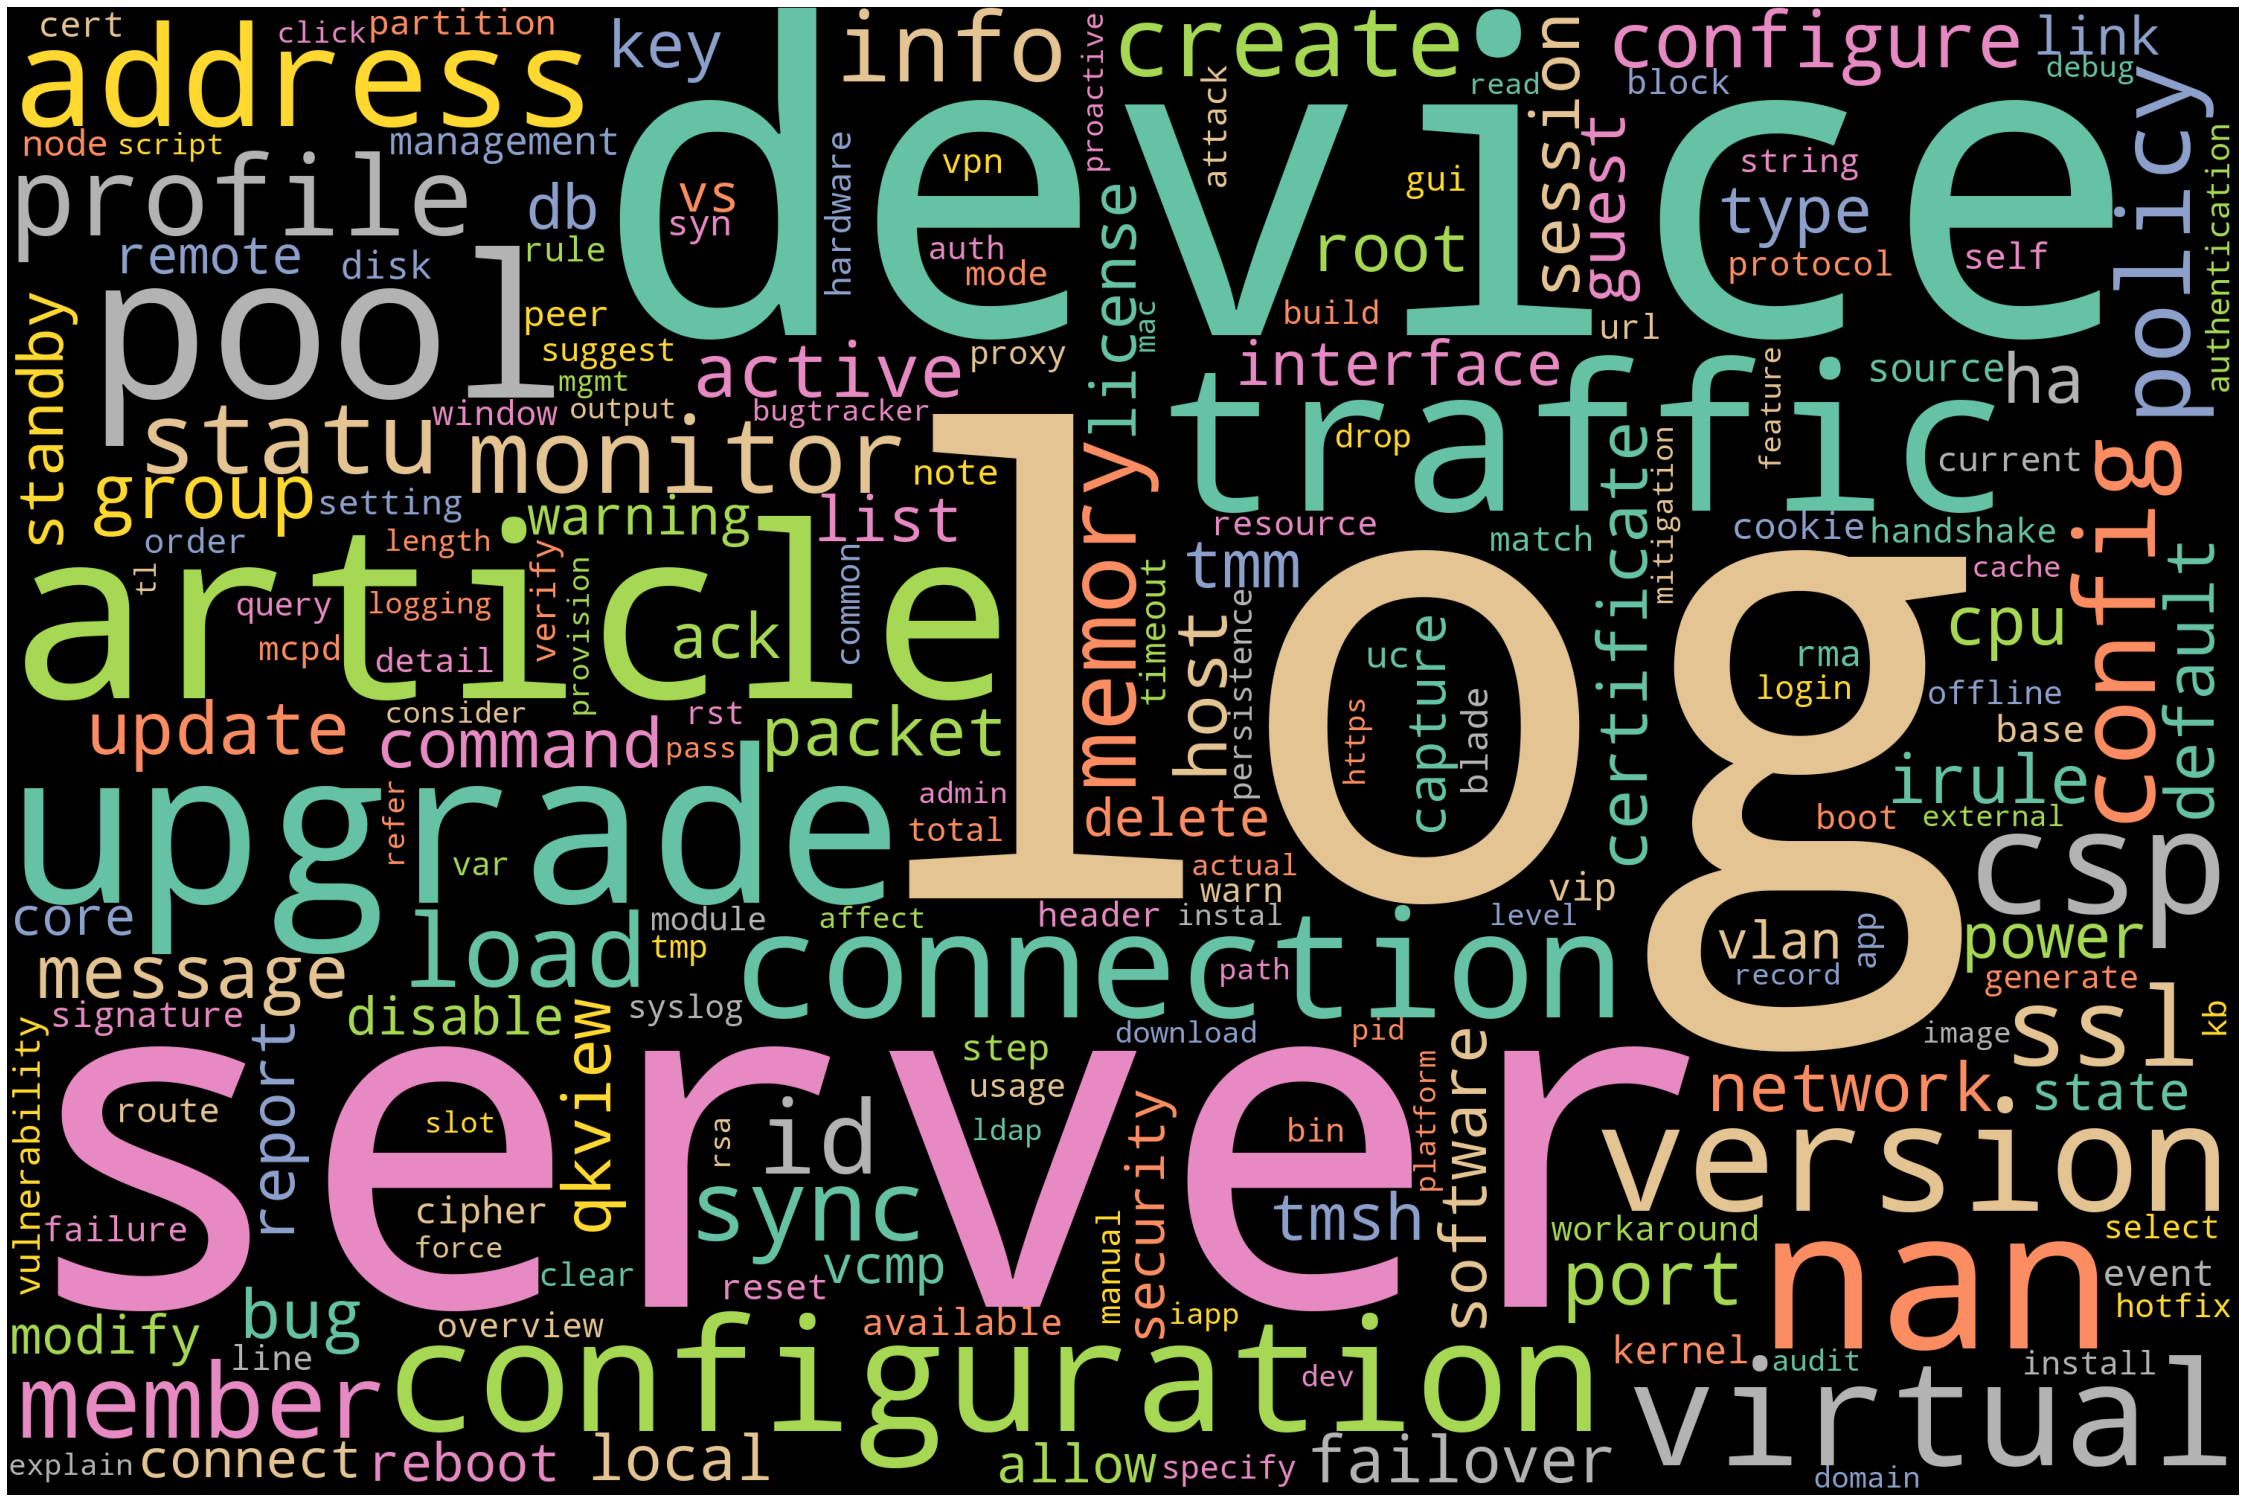

In [24]:
# Plot word cloud for PAR
PAR = ' '.join(str(v) for v in df["Processed_PAR"])
par_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(PAR)
plot_cloud(par_wordcloud)

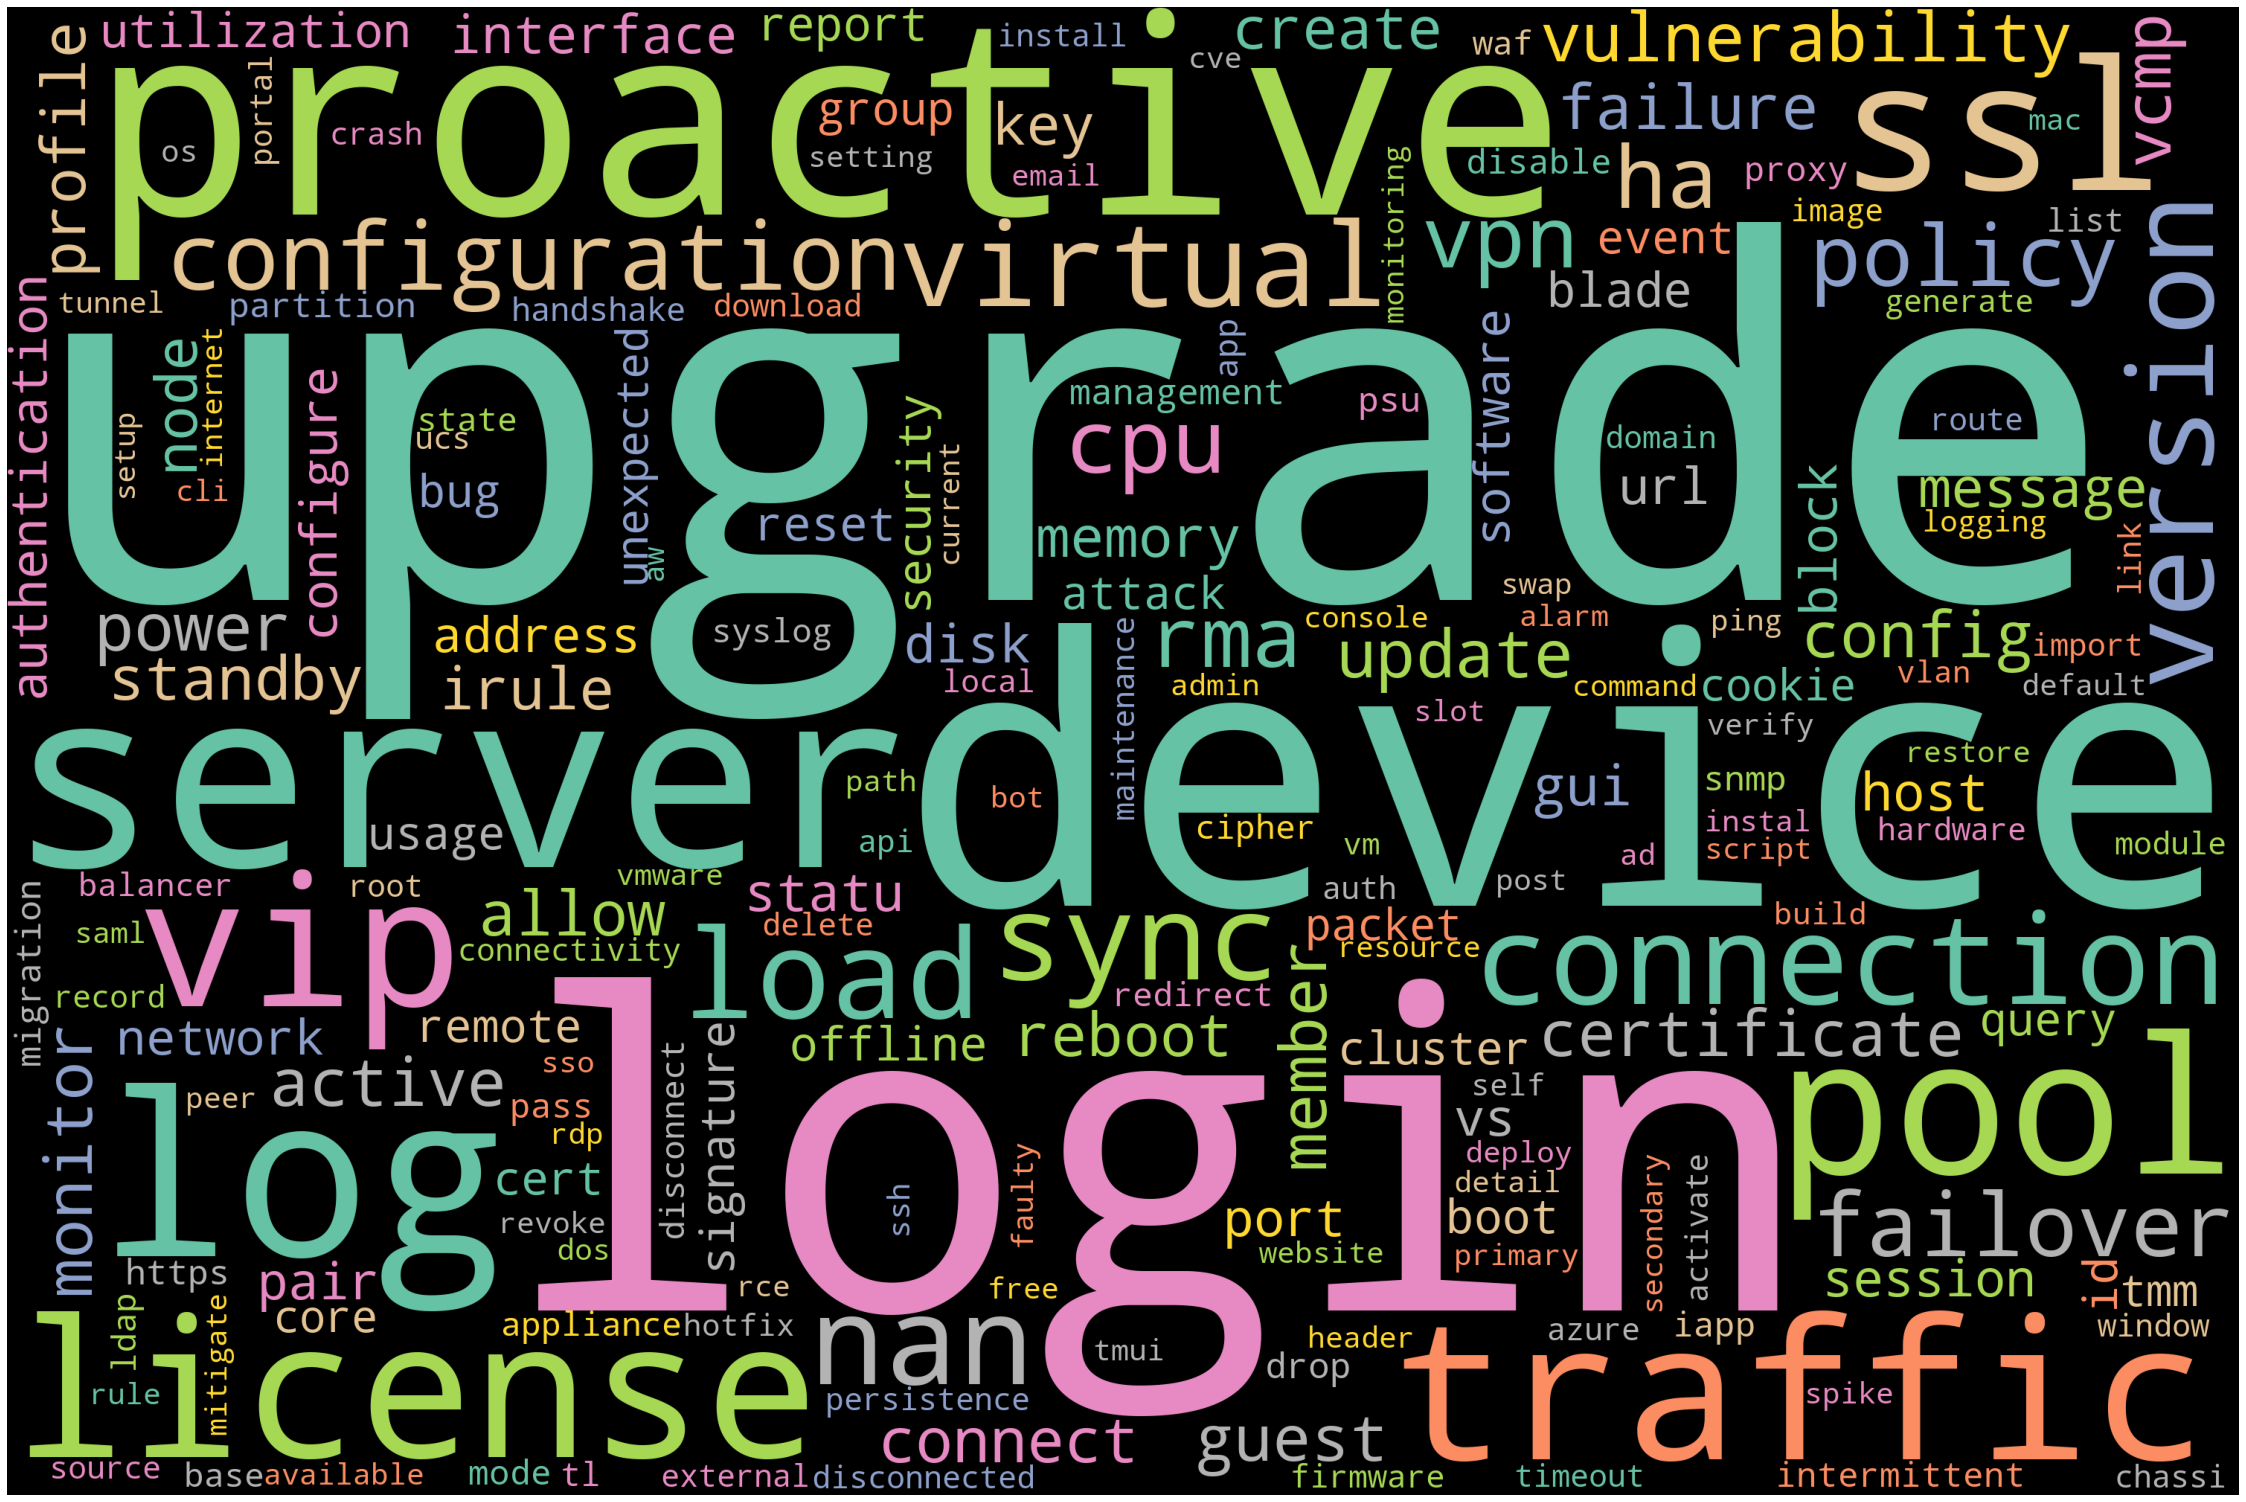

In [25]:
# Plot word cloud for abstract
abstract = ' '.join(str(v) for v in df["Processed_Abstract"])
abstract_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(abstract)
plot_cloud(abstract_wordcloud)

## Identify top 200 words from each of the 10 products

In [ ]:
from collections import Counter

In [ ]:
data = pd.read_csv("/data/nus/combine_sr.csv")

In [ ]:
products = df.F5_Product.value_counts().index[:10]

In [ ]:
topwords = [];
for product in products:
    filtered_df = df[df.F5_Product == product];
    abstract = Counter(" ".join(str(sen) for sen in filtered_df['Processed_Abstract']).split())
    PAR = Counter(" ".join(str(sen) for sen in filtered_df["Processed_Abstract"]).split())
    topwords.extend(sorted(abstract, key = lambda k : abstract[k], reverse=True)[:300]);
    topwords.extend(sorted(PAR, key = lambda k : PAR[k], reverse=True)[:300]);    

In [ ]:
noduplicate = set(topwords)
print("Number of unique words is " + str(len(noduplicate)))

In [ ]:
# write the top frequency words to file
f = open("frequentword.txt", "a");
for word in noduplicate:
    f.write(word+"\n");
f.close();